In [2]:
from encodings.hex_codec import hex_encode
from random import sample

# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.matlab.tests.test_mio import theta
from scipy.signal import welch, firwin2, fftconvolve,stft,filtfilt
from scipy.io import savemat,loadmat
from scipy.interpolate import interp1d


In [2]:
def generate_target_psd_noise(filter_order,samples,psd,noise,freq_vec):
    b = firwin2(filter_order + 1,freq_vec/(samples/2) ,np.sqrt(psd))
    output_noise = np.sqrt(samples)* fftconvolve(b,noise)
    return output_noise
def innerprodpsd(xVec,yVec,sampFreq,psdVals):
    nsamples  = len(xVec)
    if len(yVec) !=nsamples:
        raise  ValueError('Vectors must be of the same length')
    kNyq = nsamples //2
    psdVals = psdVals[:kNyq]
    if len(psdVals)  != kNyq:
        raise ValueError('PSD values must be specified at positive  DFT  freqencies')
    fftX = np.fft.fft(xVec)
    fftY = np.fft.fft(yVec)
    
    negFStrt = 1- (nsamples % 2)
    psdVec4Norm = np.concatenate((psdVals,psdVals[kNyq  - negFStrt::-1][0:]))
    dataLen = sampFreq* nsamples
    innProd  = (1 / dataLen) * np.dot(fftX/ (psdVec4Norm[:len(fftX)] + 1e-35),np.conj(fftY))
    innProd = np.real(innProd)
    return innProd
    

## SIS Model波形
#### 波形公式
- 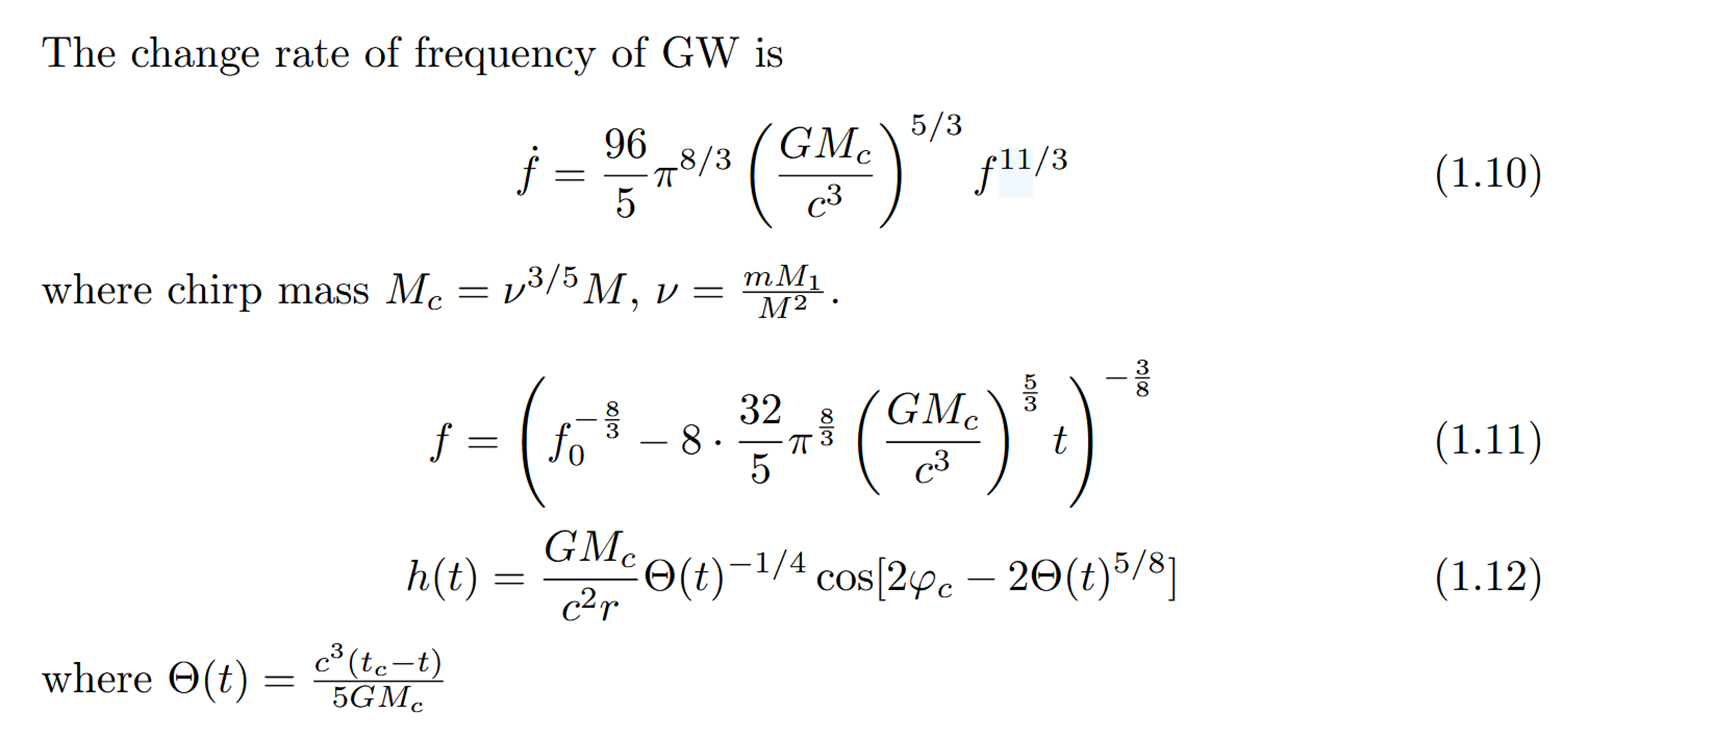
#### 透镜公式(SIS模型)
- 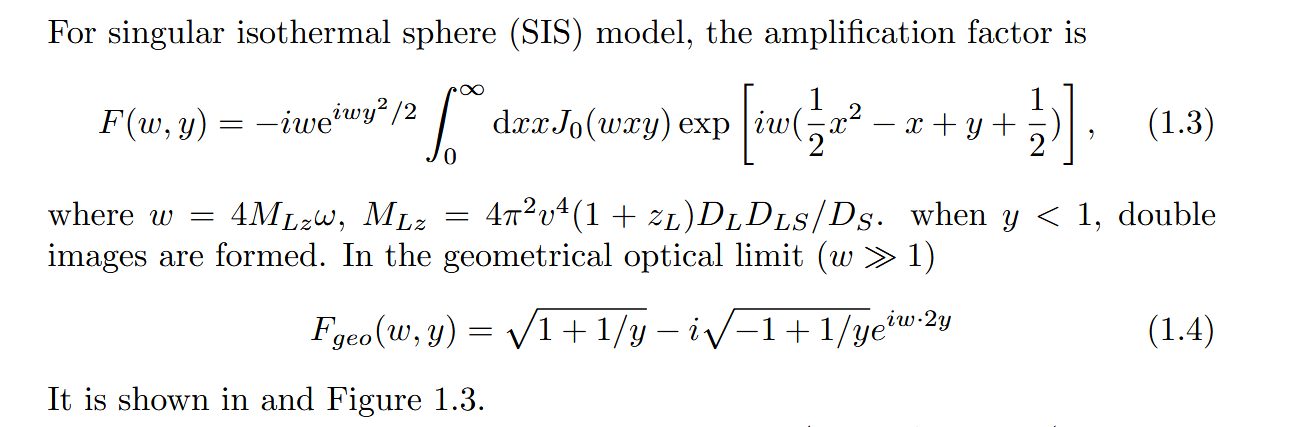
#### 待观测数据
- 所需探测范围
    - 信号：r、Mc、tc、phi_c 
    - 透镜：Mlz、 y

-2.875605013993004e+22
Two most significant peaks:
Time: 4.99 s, Value: 6.53e-22
Time: -14.71 s, Value: 5.12e-22


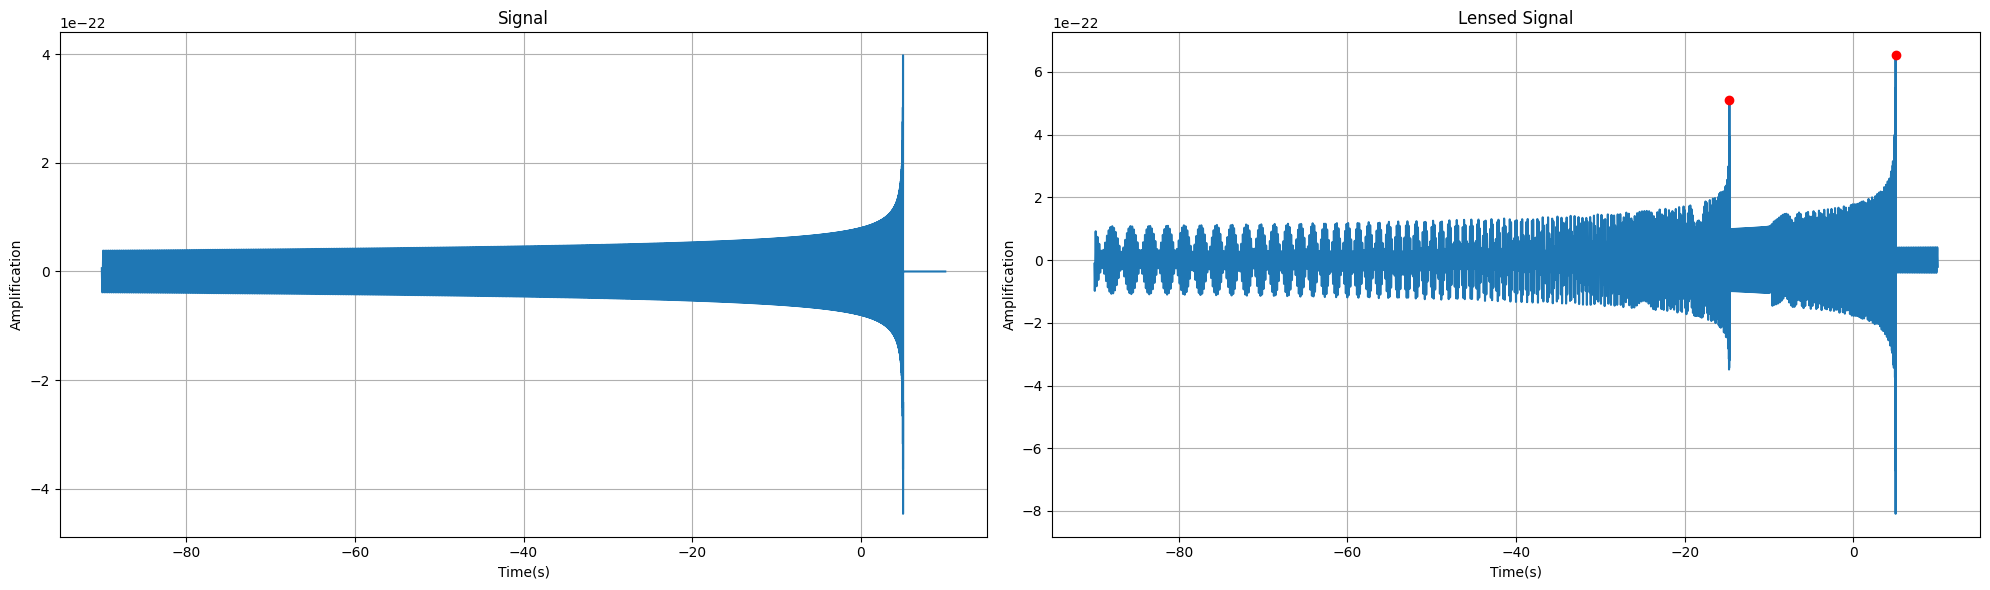

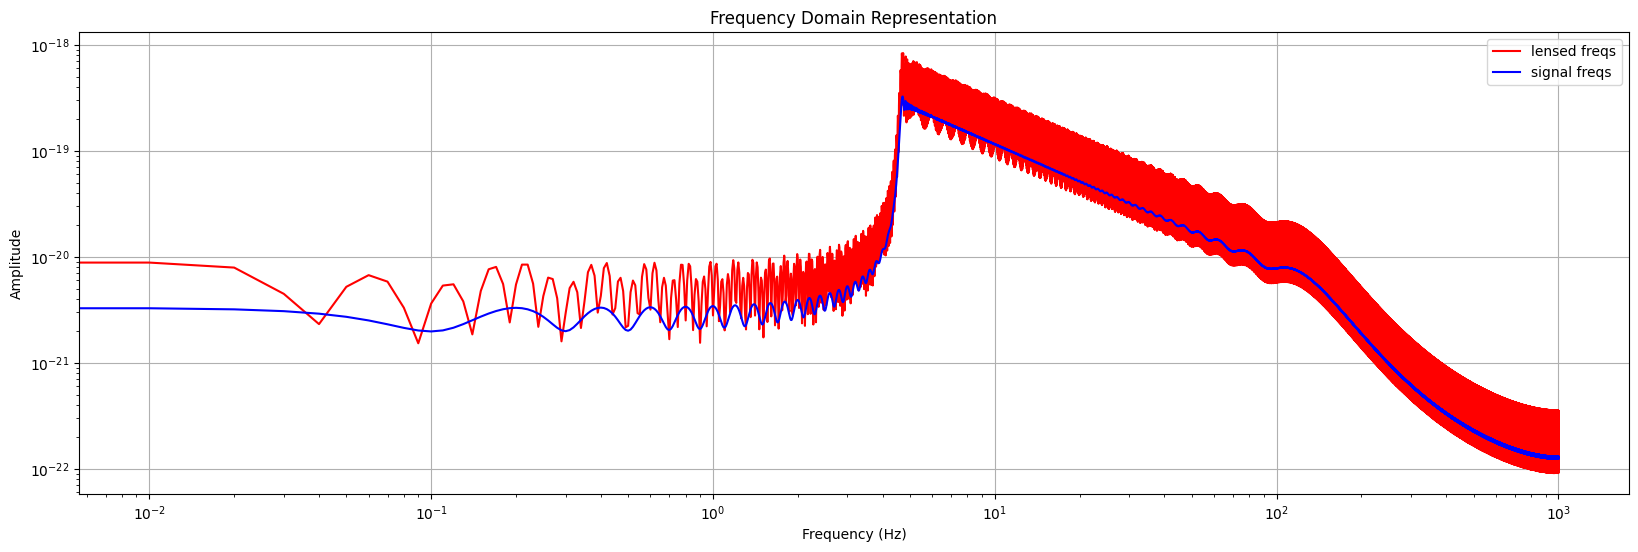

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 常量定义
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 20 * M_sun  # 增大质量使频率降低
M2 = 20 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2  # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
r = 1000 * 1e6 * pc  # 引力波源到观测者的距离，单位Mpc
t_c = 5.0  # 合并时间
phi_c = 1 * np.pi  # 合并时刻的相位

# 降低采样率，增加时间范围，使波形变化更平缓
deltaT = 0.0005   # 采样率Hz
t = np.arange(-90, 10, deltaT)  # 增加时间范围，让信号有更多的低频部分

# 定义引力波信号函数
def generate_h_t(t, M_c, r, phi_c, t_c):
    if t < t_c:
        theta_t = c**3 * (t_c - t) / (5 * G * M_c)
        if theta_t > 10:
            h = G * M_c / (c**2 * r) * theta_t**(-1/4) * np.cos(2*phi_c - 2*theta_t**(5/8))
        else :
            h = 0
    else:
        h = 0
    return h
# 向量化函数
h = np.zeros_like(t, dtype=float)
for i, ti in enumerate(t):
    h[i] = generate_h_t(ti, M_c, r, phi_c, t_c)

# 去除可能的无穷大或NaN值
h = np.nan_to_num(h)

# 将信号转换到频域
h_f = np.fft.rfft(h)

# 生成频率
freqs = np.fft.rfftfreq(len(h), deltaT)

# 透镜参数定义
Mlz = 1e6 * M_sun
omega = 2 * np.pi * freqs
w = G * 4 * Mlz * omega / c**3
y = 0.5

# 定义光学极限的透镜化SIS模型
def generate_f_geo(w, y):
    F_geo = np.ones_like(w, dtype=complex)
    for i, wi in enumerate(w):
        if y < 1:
            F_geo[i] = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1/y) * np.exp(1j * wi * 2 * y)
        else:
            F_geo[i] = np.sqrt(1 + 1/y)
    return F_geo

# 生成透镜化，频域
F_geo = generate_f_geo(w, y)


# 将信号透镜化（频域）
lens_f = h_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f)

# 检测峰值
peaks, properties = find_peaks(h_lens, height=1e-22, distance=1000)
peak_times = t[peaks]
peak_values = h_lens[peaks]

# 只取两个最显著的峰值
sorted_peaks = sorted(zip(peak_times, peak_values), key=lambda x: abs(x[1]), reverse=True)
top_two_peaks = sorted_peaks[:2]
top_of_time = top_two_peaks[0]
top_of_values = top_two_peaks[1]

# 打印结果
print("Two most significant peaks:")
for time, value in top_two_peaks:
    print(f"Time: {time:.2f} s, Value: {value:.2e}")
    
# 绘图
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(t, h, label='signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('Signal')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t, h_lens, label='lensed signal')
plt.plot([p[0] for p in top_two_peaks], [p[1] for p in top_two_peaks], 'ro', label='Peaks')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('Lensed Signal')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(freqs, np.abs(lens_f), 'red', label='lensed freqs')
plt.plot(freqs, np.abs(h_f), 'blue', label='signal freqs')
plt.legend()
plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Representation')
plt.grid(True)
plt.show()


## LIGO提供的PSD相关数据

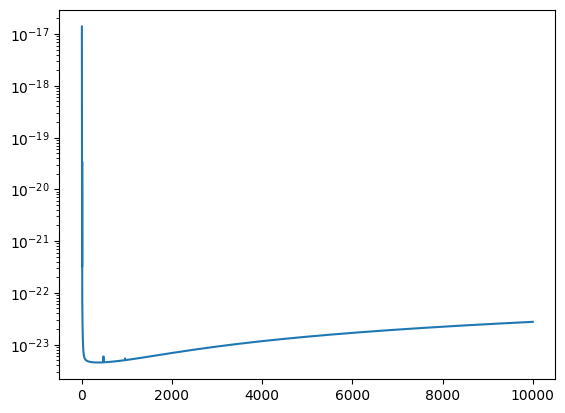

In [8]:
# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')
posfreqs = freq_psd[:,0]
psd_txt = freq_psd[:,1]
plt.plot(posfreqs,psd_txt)
plt.yscale('log')

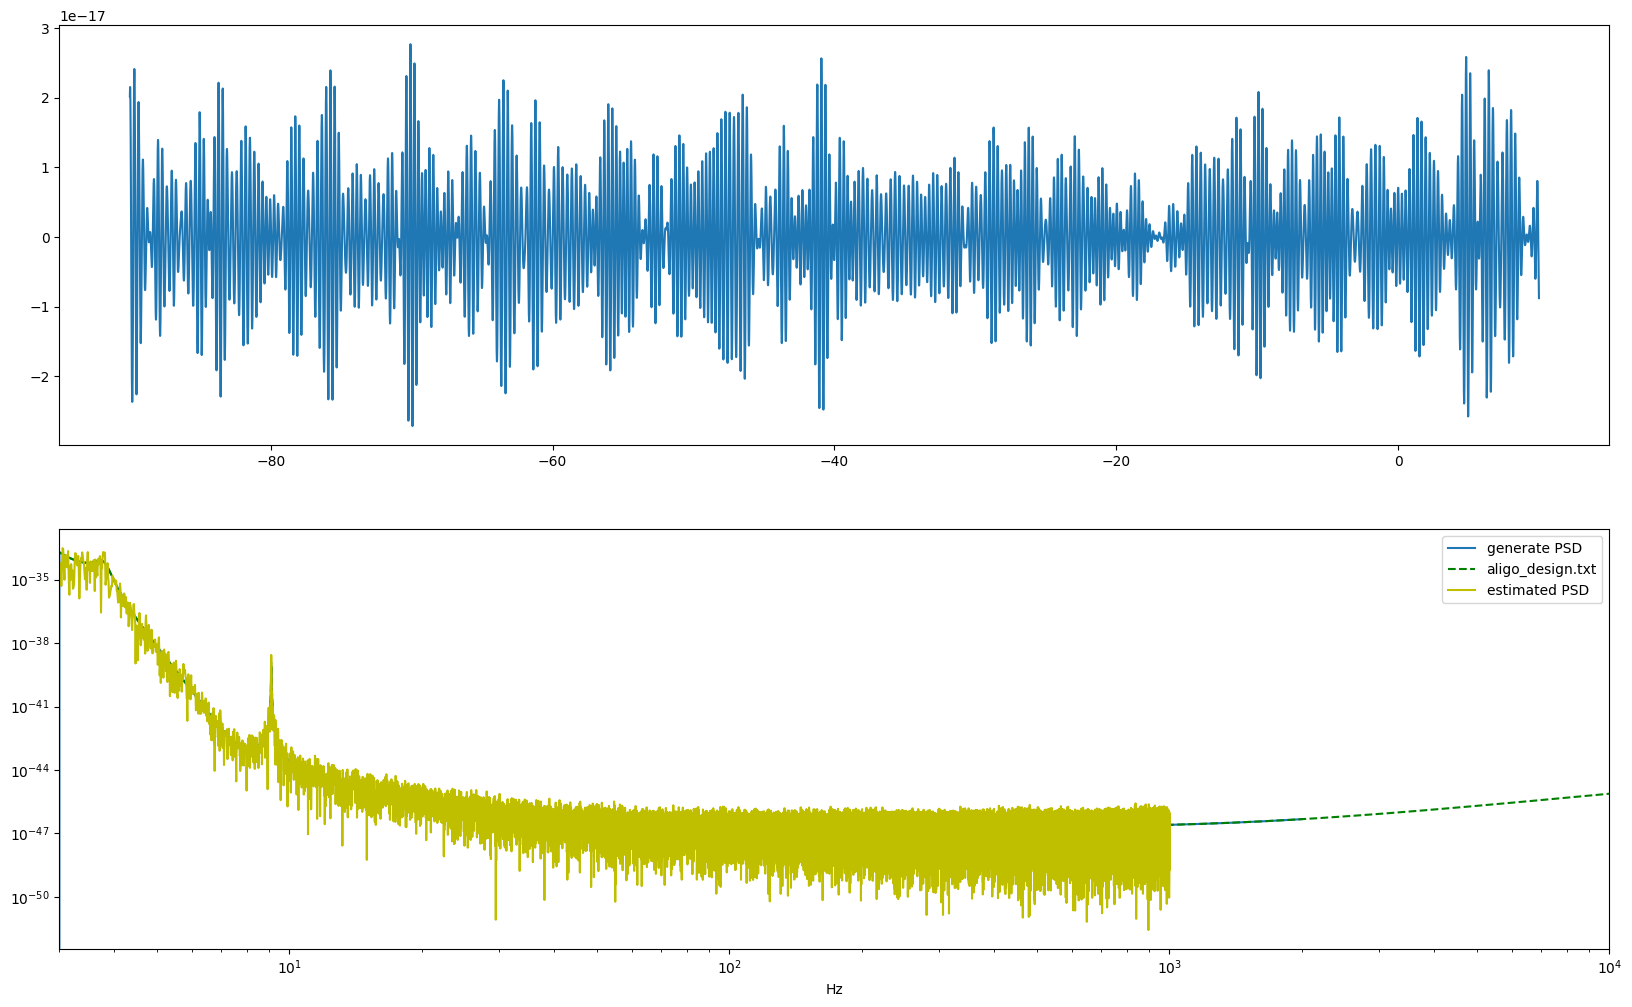

In [14]:
import pycbc.psd
import pycbc.noise
import pycbc.types
filename = 'aligo_design.txt'

delta_f = 1.0 / 100
samples = 2000
length = int(samples / delta_f)
low_frequency_cutoff = 3.0
# The PSD will be interpolated to the requested frequency spacing(按照要求的频率间隔进行插值)
# 如果是asd，则进行平方操作
psd = pycbc.psd.from_txt(filename, length, delta_f,
                         low_frequency_cutoff, is_asd_file=True)
fig = plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
delta_t = 1/samples 
outNoise = pycbc.noise.noise_from_psd(length, delta_t, psd,seed = 516)

estimated_psd = pycbc.psd.welch(outNoise,int(100/delta_t),int(100/delta_t/2))
plt.plot(t,outNoise,label = 'signal')
plt.subplot(2,1,2)
plt.loglog(psd.sample_frequencies, psd, label='generate PSD')
plt.xlim(xmin=3, xmax=10000)
plt.loglog(posfreqs,psd_txt ** 2, 'g--',label='aligo_design.txt')
plt.yscale('log')
plt.xlabel('Hz')
plt.plot(estimated_psd.sample_frequencies,estimated_psd,'y',label='estimated PSD')
plt.legend()
plt.show()


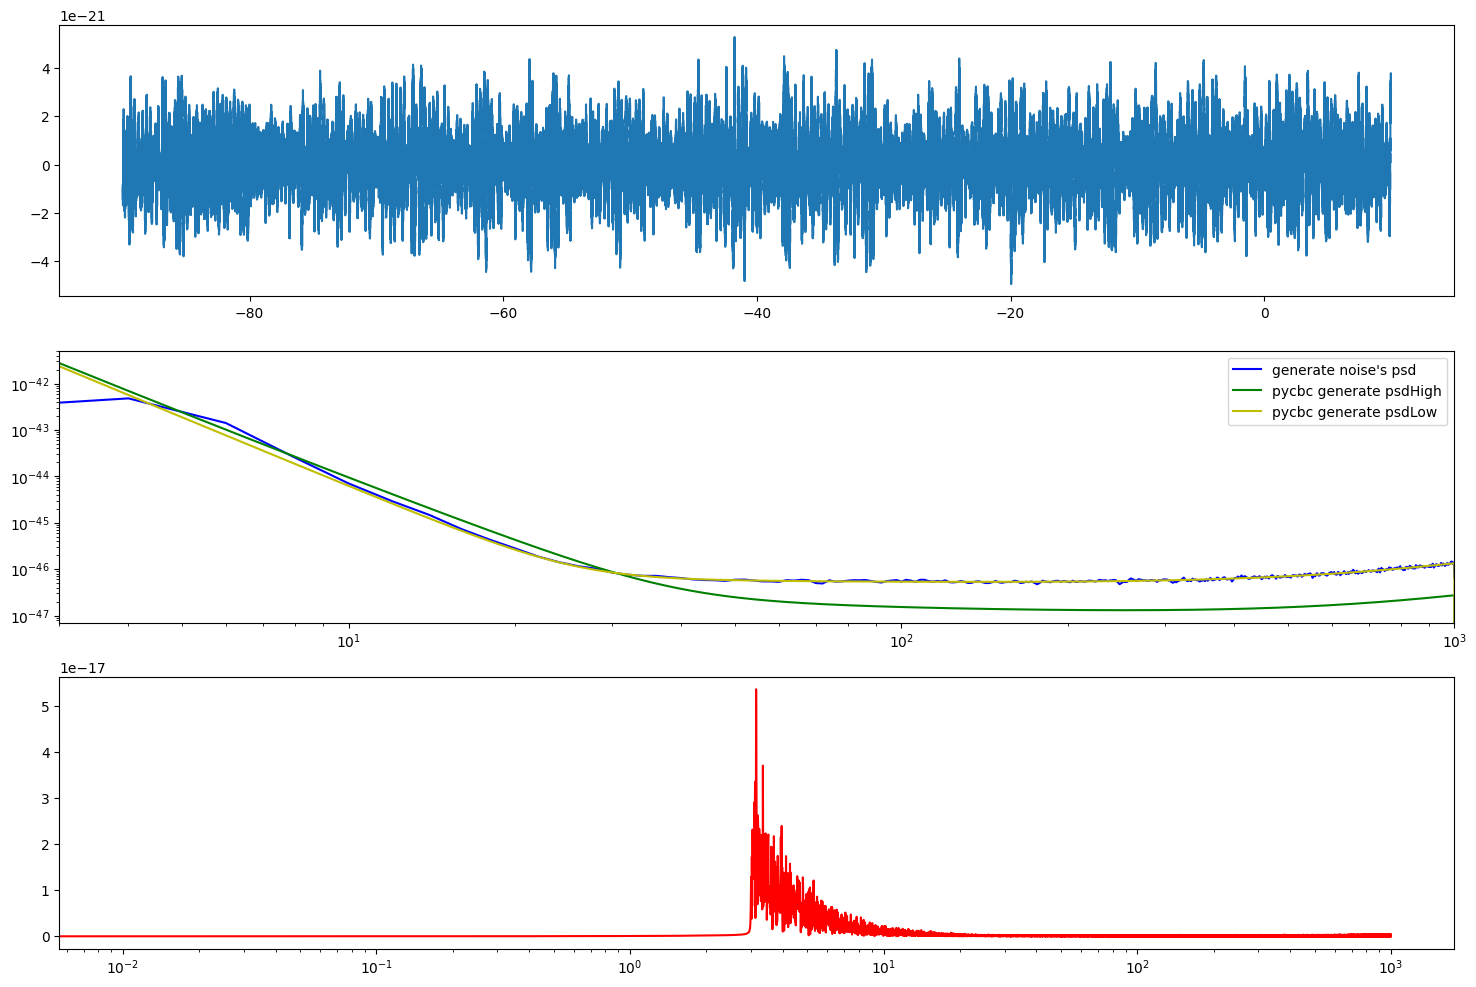

In [20]:
import matplotlib.pyplot as plt
import pycbc.noise
import pycbc.psd
import numpy as np
from scipy.signal import welch

# psd 参数
flow = 3 # 最低频率为3Hz
delta_f = 1.0 / 100 # 频率分辨率
nyq_freq = 1000
flen = int(nyq_freq / delta_f) + 1
# 生成两种PSD的两种方式
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(flen,delta_f,flow)

psdLow = pycbc.psd.from_string('aLIGOZeroDetLowPower',flen,delta_f,flow)
# psd = psdHigh + psdLow
# 噪声参数
delta_t = 1.0 / 2000
tsamples = 200000
duration = tsamples * delta_t
samples = tsamples / duration

outNoise = pycbc.noise.noise_from_psd(tsamples,delta_t,psdLow,seed= 123)
freqs = np.fft.rfftfreq(len(outNoise),t[1]-t[0])

f,pxx = welch(outNoise,fs = samples,nperseg=samples/2)
f_noise = np.fft.rfft(outNoise)
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(t,outNoise)

plt.subplot(312)
plt.plot(f,pxx,'b',label = "generate noise's psd")
# plt.plot(freqs,psd,'r',label = "psd = psdHigh + psdLow")
plt.plot(freqs,psdHigh,'g',label = "pycbc generate psdHigh")
plt.plot(freqs,psdLow,'y',label = "pycbc generate psdLow")
plt.yscale('log')
plt.xlim(low_frequency_cutoff,nyq_freq)
plt.legend()
plt.xscale('log')
plt.subplot(313)
plt.plot(freqs,np.abs(f_noise),'r')
plt.xscale('log')
plt.show()
savemat('noise.mat',{'noise':outNoise})

# 将噪声混入信号
- 左图为透镜化之后的信号以及噪声情况
- 右图为透镜化之后的信号与混合数据的情况
- 取值情况为噪声约为信号的10-100倍强度
## 之后用数据代指       透镜化信号+噪声

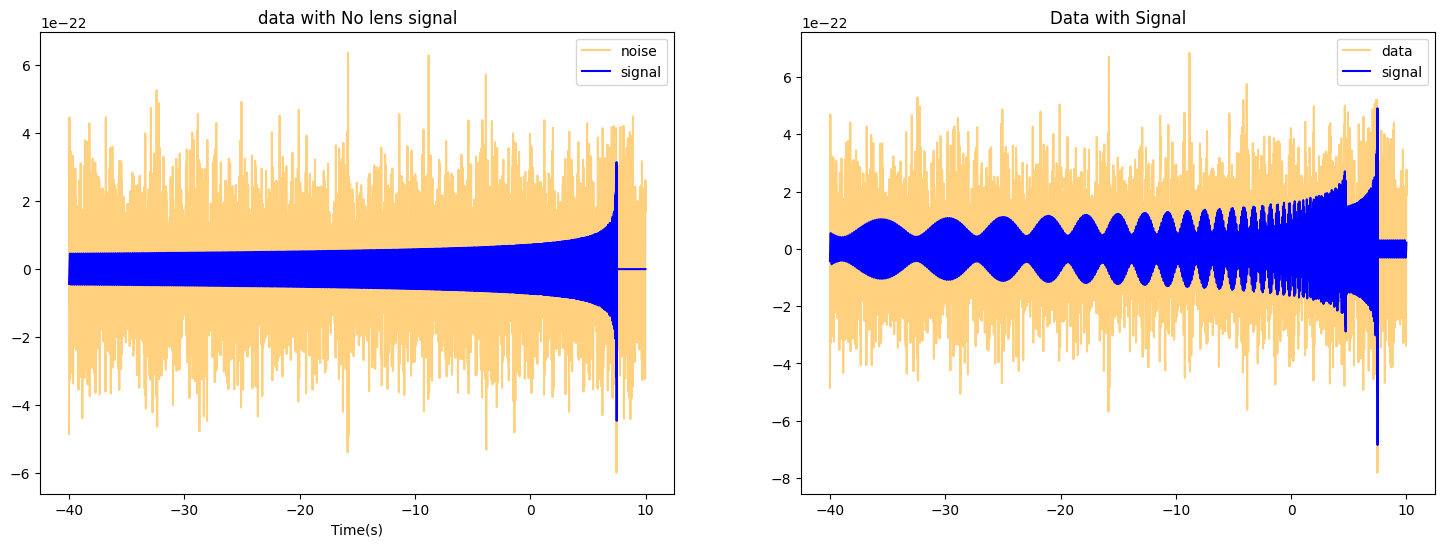

In [8]:
# h = h[:len(output_noise)]
# data = h + output_noise

data = h_lens + outNoise
data_no_lens = h + outNoise

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图
axs[0].plot(t, data_no_lens, "orange", label="noise", alpha=0.5)
axs[0].plot(t, h, "blue", label='signal')
axs[0].set_xlabel("Time(s)")
axs[0].set_title("data with No lens signal")
axs[0].legend()

# 第二个子图
axs[1].plot(t, data, "orange", label="data", alpha=0.5)
axs[1].plot(t, h_lens, "blue", label='signal')
axs[1].set_title("Data with Signal")
axs[1].legend()

plt.show()

savemat('data.mat',{'data':data,'samples':samples})
savemat('data_No_lens.mat',{'data':data_no_lens,'samples':samples})
# print(np.isinf(data).any())

# 绘制噪声与数据的功率谱密度
- 蓝色线代表总数据
- 橙色线代表纯噪声


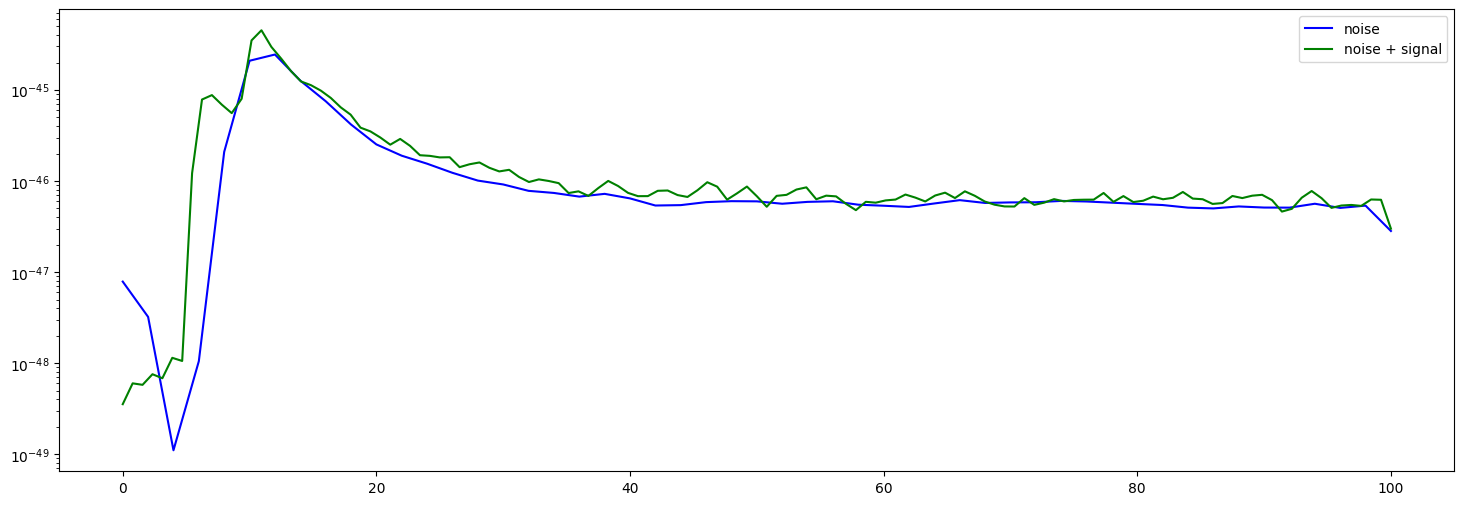

In [9]:
[f_data,pxx_data] = welch(data,fs = samples,window = "hamming",nperseg=256,noverlap=None,nfft=None,detrend = False)

fig = plt.figure(figsize=(18,6))
plt.plot(f,pxx,'blue',label = 'noise')
plt.plot(f_data,pxx_data,"green",label = 'noise + signal')
plt.yscale('log')
plt.legend()
# plt.xlim(0,250)
plt.show()

In [10]:
# 查看数据是否可以调用
# data = loadmat("data.mat")
# noise = loadmat("noise.mat")

# samples_data = data['samples'][0]
# dataY = data['data'][0]
# noise_y = noise['noise'][0]
# dataY_FFT = np.fft.fft(dataY)
# print(np.any(np.isinf(dataY_FFT)))

## 信噪比
- 在学习信噪比时看到的一个很好理解的视频
    - https://www.bilibili.com/video/BV1NG411b7qD/?spm_id_from=333.1391.0.0&vd_source=6653954c04b5fa19db6e649a79e0d4dd

In [11]:
# # 计算信噪比
# print(len(data),len(h_lens),len(outNoise))
# llrH0 = np.zeros(1000)
# for lp in range(len(llrH0)):
#     llrH0[lp] = innerprodpsd(outNoise,h_lens,samples,freqs)
# llrH1 = np.zeros(1000)
# for lp in range(len(llrH1)):
#     llrH1[lp] = innerprodpsd(data,h_lens,samples,freqs)

# estSNR = (np.mean(llrH1) - np.mean(llrH0)) / np.std(llrH0)

# print(estSNR)


In [12]:
print(f"r: {r / 1e6 / pc:.4f} m_c: {M_c/M_sun:.4f} t_c: {t_c} phi_c: {phi_c / np.pi} Mlz: {Mlz/M_sun:.4e} y: {y}")

r: 1000.0000 m_c: 17.4110 t_c: 7.5 phi_c: 1.0 Mlz: 1.0000e+05 y: [           inf 9.59691552e+01 4.27493987e+01 ... 4.64375585e-03
 4.64267211e-03 4.64158883e-03]


/home/ywq/anaconda3/envs/Ubuntu/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ywq/anaconda3/envs/Ubuntu/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


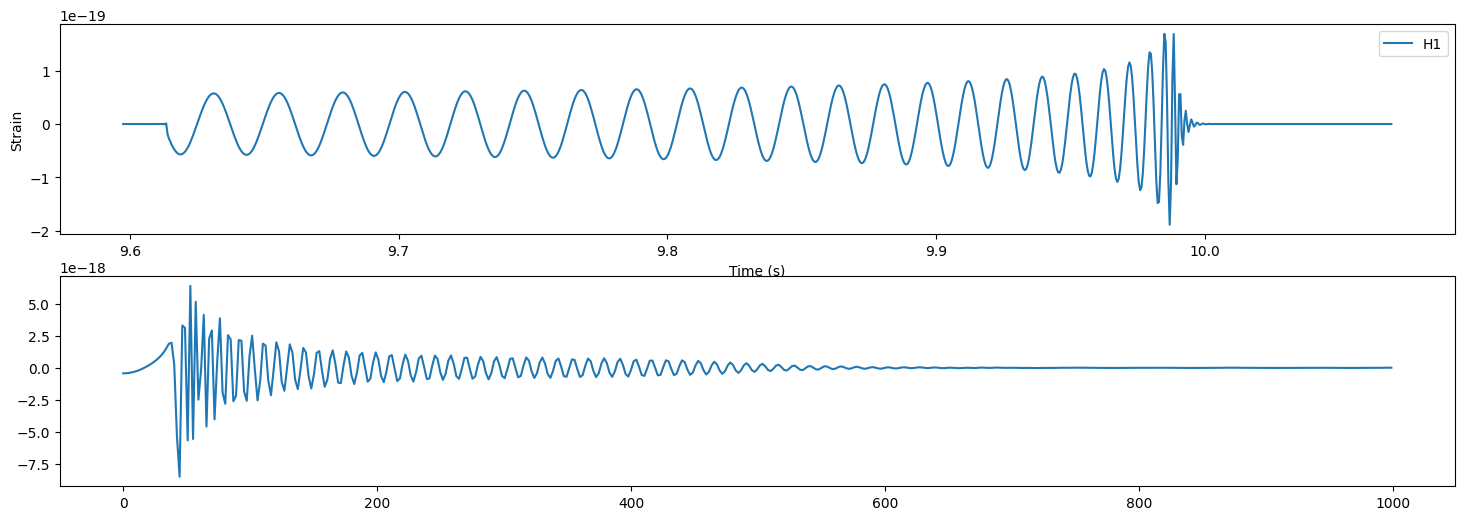

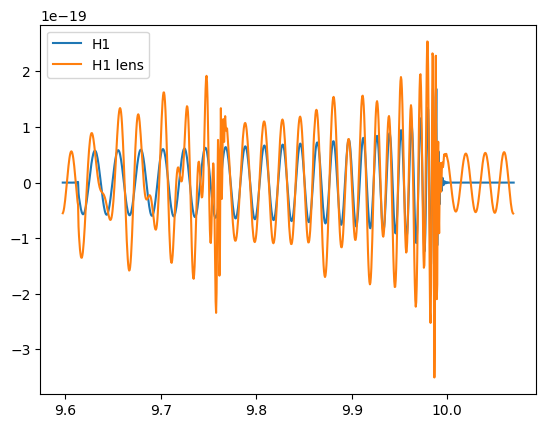

In [13]:
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

apx = 'SEOBNRv4'
hp,hc = get_td_waveform(approximant=apx,
                        mass1 = 10,
                        mass2 = 25,
                        delta_t = 1 / 2000,
                        f_lower = 40)

det_h1 = Detector('H1')
end_time = 10
declination = 0.65
right_ascension = 4.67
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)

freqs = np.fft.rfftfreq(len(signal_h1),signal_h1.sample_times[1] - signal_h1.sample_times[0])
f_signal_h1 = np.fft.rfft(signal_h1)
fig = plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(signal_h1.sample_times, signal_h1, label='H1')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.subplot(212)
plt.plot(freqs,f_signal_h1)
plt.show()


h_f = np.fft.rfft(signal_h1)

# 透镜参数定义
Mlz = 1e7* M_sun
omega = 2 * np.pi * freqs
w = G * 4 *Mlz * omega / c**3
y = 0.6

# 定义光学极限的透镜化SIS模型
def generate_f_geo(w,y):
    if y <1 : 
        F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    else :
        F_geo = np.sqrt(1 + 1 / y)
    return F_geo
# 生成透镜化，频域
F_geo = generate_f_geo(w,y)
h_f_len = h_f * F_geo

h_t_len = np.fft.irfft(h_f_len)
plt.plot(signal_h1.sample_times, signal_h1, label='H1')
plt.plot(signal_h1.sample_times[:len(h_t_len)], h_t_len, label='H1 lens')
plt.legend()
plt.show()